<a href="https://colab.research.google.com/github/Gonzalo-Ortega/Stereotypical-Behavior-Classification/blob/main/DeepLabCut_Gonzalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial configuration**
---

### Conect GPU

Enabling and testing the GPU
First, you'll need to enable GPUs for the notebook:

Navigate to Edit → Notebook Settings
select GPU from the Hardware Accelerator drop-down.

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
%tensorflow_version 2.2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


**Everything before creating your training dataset should be done in your PC! COLAB does not allow you to label the frames or do any type of image processing.**

### Import DeepLabCut

In [ ]:
# Clone the entire deeplabcut repo so we can use the demo data:
!git clone -l -s https://github.com/DeepLabCut/DeepLabCut.git cloned-DLC-repo
%cd cloned-DLC-repo
!ls

In [ ]:
# Install the latest DeepLabCut version (this will take a few minutes to install all the dependencies!)
%cd /content/cloned-DLC-repo/
!pip install '.[tf]'

In [ ]:
import deeplabcut

### Import other libraries and Google Drive

Usefull python libraries:

- Matplotlib: Plotting and data visualization.
- Pandas: Data management. Is most commonly used for data wrangling and data manipulation purposes.
- NumPy: Used to create arrays or matrices that can be applied to DL or ML models.

In [ ]:
# Data processing
import pandas as pd
import numpy as np

from scipy.stats import binom
from scipy.special import comb

# Figures
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Data preprocesing and modeling
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Others
import os
import fnmatch
import cv2
import re
import random


from google.colab import files
from typing import List, Tuple


In [ ]:
# Mount your Google Drive so the colab its allow to get data from there.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Test analysis

---



## Test variables

In [ ]:
start_frame = 200
frame_rate = 20

In [ ]:
ProjectFolderName = 'TestGonzalo/test-Gonzalo-2024-01-31'
VideoType = 'avi'

# List of videos or folder to analyze:
videofile_path = '/content/gdrive/MyDrive/TestGonzalo/test-Gonzalo-2024-01-31/videos'

In [ ]:
# Path variable that links to your google drive copy:
path_config_file = '/content/gdrive/MyDrive/TestGonzalo/test-Gonzalo-2024-01-31/config.yaml'

We start by reading the .csv data file with panda.



In [ ]:
csv_file_path = '/content/gdrive/MyDrive/SBC-Gonzalo/test-Gonzalo-2024-01-31/videos/Mouse4089_2020-09-12_12-35-53_beh-CROPDLC_resnet50_test2Jan31shuffle1_1000.csv.py'
pd.set_option('display.max_columns', 25)

data = pd.read_csv(csv_file_path, header = [1,2])
data.columns = list(data.columns.get_level_values(0)
                    + data.columns.get_level_values(1))
data['nosey'] = -data['nosey']
data['lefteary'] = -data['lefteary']
data['righteary'] = -data['righteary']
data['tailbasey'] = -data['tailbasey']

data

,bodypartscoords,nosex,nosey,noselikelihood,leftearx,lefteary,leftearlikelihood,rightearx,righteary,rightearlikelihood,tailbasex,tailbasey,tailbaselikelihood
0,0,188.359619,-162.139664,0.583664,193.199356,-161.716171,0.645357,207.538666,-163.526138,0.835253,224.756256,-182.265137,0.838431
1,1,167.012009,-54.417149,0.450149,171.169144,-65.555733,0.591849,174.225296,-47.762501,0.669895,206.304230,-70.208618,0.812052
2,2,167.204666,-54.429623,0.458724,171.716034,-65.814964,0.599467,174.745682,-48.217674,0.671654,206.498932,-68.663765,0.806171
3,3,167.854431,-54.557251,0.424334,171.946518,-66.081879,0.645759,174.888306,-48.293522,0.641056,206.186890,-71.133408,0.819126
4,4,160.721466,-66.781967,0.468899,172.168793,-65.957581,0.634085,176.094467,-49.338749,0.621469,206.845383,-70.048546,0.854399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,6276,150.704773,-69.422165,0.624349,136.237030,-76.031113,0.611090,153.913116,-78.647369,0.717826,151.259811,-103.997528,0.654442
6277,6277,150.877350,-69.757614,0.647144,136.699173,-76.110054,0.611457,154.117279,-78.967903,0.713933,151.517975,-104.526321,0.652367
6278,6278,150.773407,-69.868233,0.652538,137.137253,-76.352287,0.618232,154.145782,-79.150131,0.707407,151.689941,-104.334145,0.657355
6279,6279,151.055069,-69.881226,0.643930,137.317886,-76.165604,0.611465,153.828064,-79.134026,0.691718,151.674866,-103.974609,0.688121


## Training



There are many parameters that can help training your network, look at them carefully. Try to understand what gives you what and play with them.

In [ ]:
# Note: if you are using the demo data (i.e. examples/Reaching-Mackenzie-2018-08-30/), first delete the folder called dlc-models!
#Then, run this cell. There are many more functions you can set here, including which netowkr to use!
#check the docstring for full options you can do!
deeplabcut.create_training_dataset(path_config_file, net_type='resnet_50', augmenter_type='imgaug')

In [ ]:
deeplabcut.train_network(path_config_file, shuffle=1, trainingsetindex=0, max_snapshots_to_keep=5, displayiters=10, saveiters=250, maxiters=1000, allow_growth=False, autotune=False, keepdeconvweights=True)

EVALUATION: You know that an error of 2 pxls is more than acceptable, don't obsess too much about this, as in the 'loss' term of the training, a 'good' error is very subjective to your data.

ANALYSIS: Once you are happy with your error. Analyze your videos and then the real thing starts!! Be aware that CSV files are much easier to read than HDF5, so try to set **save_as_csv=True** and save you some trouble!

In [ ]:
deeplabcut.evaluate_network(path_config_file)

In [ ]:
deeplabcut.analyze_videos(path_config_file, ['/content/gdrive/MyDrive/TestGonzalo/test-Gonzalo-2024-01-31/videos/Mouse4089_2020-09-12_12-35-53_beh-CROP.avi'], videotype='.avi', shuffle=1, trainingsetindex=0, save_as_csv=True, destfolder=None, batchsize=None, cropping=None, TFGPUinference=True, robust_nframes=False, allow_growth=True, use_shelve=False, auto_track=True, n_tracks=None, calibrate=False, identity_only=False, use_openvino=None)

It is always nice to see the final result! So use this last line of code to create a video an look at the bodyparts dots.

In [ ]:
deeplabcut.create_labeled_video(path_config_file, ['/content/gdrive/MyDrive/TestGonzalo/test-Gonzalo-2024-01-31/videos/Mouse4089_2020-09-12_12-35-53_beh-CROP.avi'], videotype='.avi', draw_skeleton=True)

## Trayectory
To picture the mouse's nose trayectory we first filter the data by its likelihood.

### Check likelihood

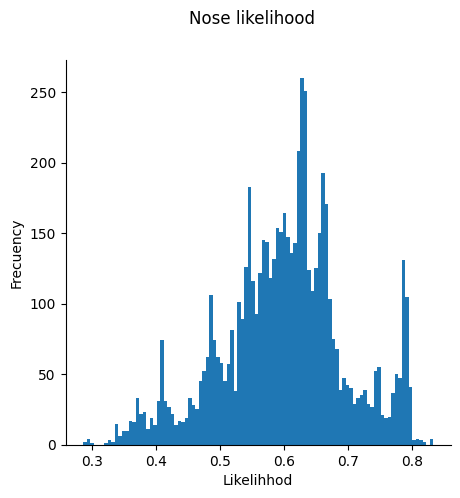

In [ ]:
# Nose likelihhod Figure #
fig = plt.figure(figsize=(5, 5))
fig.suptitle('Nose likelihood')

ax1 = fig.add_subplot(111)
ax1.hist(data['noselikelihood'], bins=100)
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('Likelihhod')
ax1.set_ylabel('Frecuency')

fig.show()

### Filter by lilekihood

In [ ]:
filtered_data = data.copy()
mask = filtered_data['noselikelihood'] < 0.55
filtered_data.loc[mask, ['nosex', 'nosey']] = np.nan

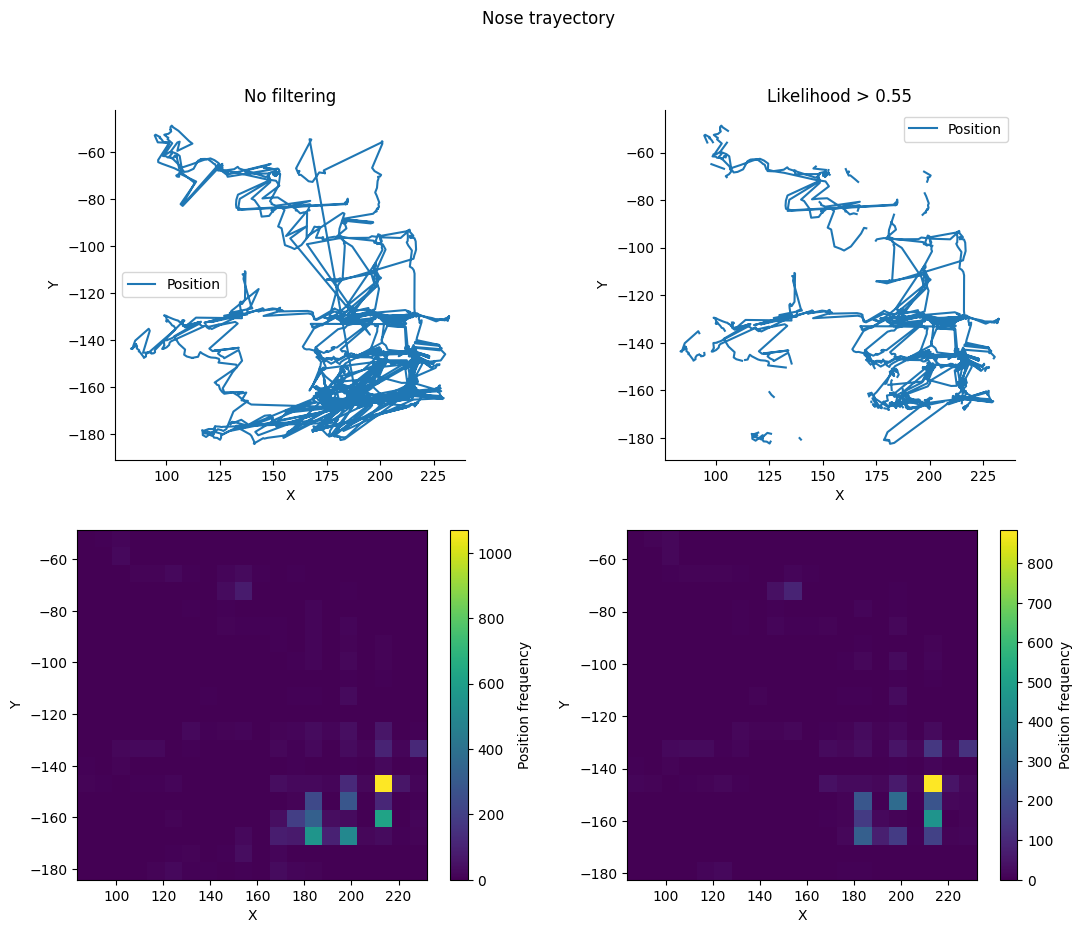

In [ ]:
# Nose trayectory Figure #

fig = plt.figure(figsize=(13, 10))
fig.suptitle('Nose trayectory')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Plot 1: No filtering
ax1.plot(data['nosex'], data['nosey'], label='Position')
ax1.title.set_text('No filtering')
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Plot 2: Likelihood > 0.55
ax2.plot(filtered_data['nosex'], filtered_data['nosey'], label='Position')
ax2.title.set_text('Likelihood > 0.55')
ax2.set_box_aspect(1)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()

# Plot 3: Heatmap - No filtering
hist = ax3.hist2d(data['nosex'], data['nosey'], bins=20)
cbar = fig.colorbar(hist[3], ax=ax3)
cbar.set_label('Position frequency')
ax3.set_box_aspect(1)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')

# Plot 4: Heatmap - Likelihood > 0.55
non_nan = ~np.isnan(filtered_data['nosex']) & ~np.isnan(filtered_data['nosey'])
hist = ax4.hist2d(filtered_data['nosex'][non_nan], filtered_data['nosey'][non_nan], bins=20)
cbar = fig.colorbar(hist[3], ax=ax4)
cbar.set_label('Position frequency')
ax4.set_box_aspect(1)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')

fig.show()

To reduce NaN data will compute the mean of the three points that form the mouse's head: the nose, the left ear and the right ear. As before, we first filter the raw data by its likelihood.

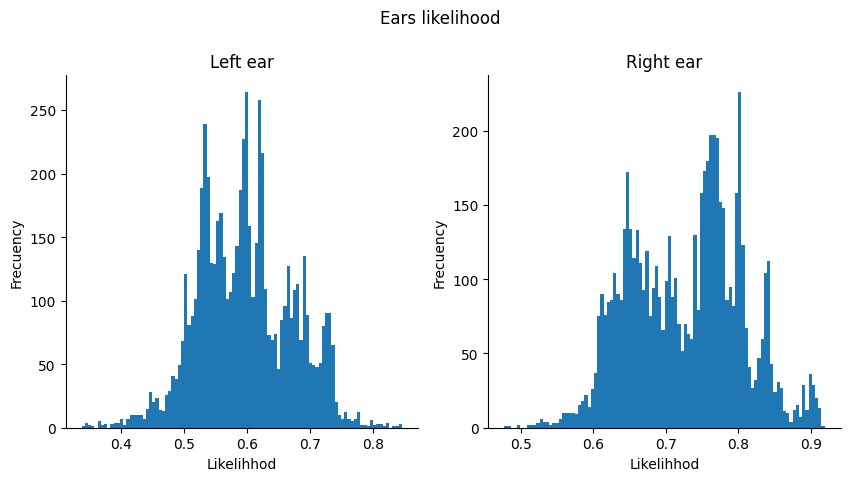

In [ ]:
# Ears likelihood Figure #

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Ears likelihood')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(data['leftearlikelihood'], bins=100)
ax1.title.set_text('Left ear')
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('Likelihhod')
ax1.set_ylabel('Frecuency')

ax2.hist(data['rightearlikelihood'], bins=100)
ax2.title.set_text('Right ear')
ax2.set_box_aspect(1)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_xlabel('Likelihhod')
ax2.set_ylabel('Frecuency')

fig.show()

In [ ]:
mask = filtered_data['leftearlikelihood'] < 0.6
filtered_data.loc[mask, ['leftearx', 'lefteary']] = np.nan

mask = filtered_data['rightearlikelihood'] < 0.7
filtered_data.loc[mask, ['rightearx', 'righteary']] = np.nan

filtered_data

,bodypartscoords,nosex,nosey,noselikelihood,leftearx,lefteary,leftearlikelihood,rightearx,righteary,rightearlikelihood,tailbasex,tailbasey,tailbaselikelihood
0,0,188.359619,-162.139664,0.583664,193.199356,-161.716171,0.645357,207.538666,-163.526138,0.835253,224.756256,-182.265137,0.838431
1,1,NaN,NaN,0.450149,NaN,NaN,0.591849,NaN,NaN,0.669895,206.304230,-70.208618,0.812052
2,2,NaN,NaN,0.458724,NaN,NaN,0.599467,NaN,NaN,0.671654,206.498932,-68.663765,0.806171
3,3,NaN,NaN,0.424334,171.946518,-66.081879,0.645759,NaN,NaN,0.641056,206.186890,-71.133408,0.819126
4,4,NaN,NaN,0.468899,172.168793,-65.957581,0.634085,NaN,NaN,0.621469,206.845383,-70.048546,0.854399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,6276,150.704773,-69.422165,0.624349,136.237030,-76.031113,0.611090,153.913116,-78.647369,0.717826,151.259811,-103.997528,0.654442
6277,6277,150.877350,-69.757614,0.647144,136.699173,-76.110054,0.611457,154.117279,-78.967903,0.713933,151.517975,-104.526321,0.652367
6278,6278,150.773407,-69.868233,0.652538,137.137253,-76.352287,0.618232,154.145782,-79.150131,0.707407,151.689941,-104.334145,0.657355
6279,6279,151.055069,-69.881226,0.643930,137.317886,-76.165604,0.611465,NaN,NaN,0.691718,151.674866,-103.974609,0.688121


### Compute head points meaan

In [ ]:
x_coords = np.array([filtered_data['nosex'], filtered_data['leftearx'], filtered_data['rightearx']])
y_coords = np.array([filtered_data['nosey'], filtered_data['lefteary'], filtered_data['righteary']])

x_means = np.nanmean(x_coords, axis=0)
y_means = np.nanmean(y_coords, axis=0)

<ipython-input-75-61bc106af134>:4: RuntimeWarning: Mean of empty slice
  x_means = np.nanmean(x_coords, axis=0)
<ipython-input-75-61bc106af134>:5: RuntimeWarning: Mean of empty slice
  y_means = np.nanmean(y_coords, axis=0)


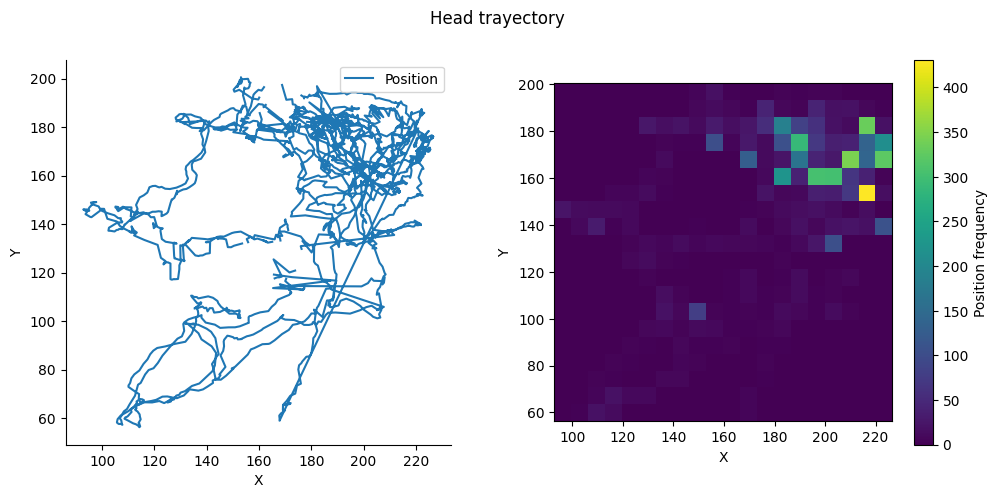

In [ ]:
# Trayectory Figure #

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Head trayectory')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot 1: Trayectory
ax1.plot(x_means, y_means, label='Position')
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Plot 2: Heatmap
non_nan = ~np.isnan(x_means) & ~np.isnan(y_means)
hist = ax2.hist2d(x_means[non_nan], y_means[non_nan], bins=20)
cbar = fig.colorbar(hist[3], ax=ax2)
cbar.set_label('Position frequency')
ax2.set_box_aspect(1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

fig.show()

### Interpolate data

To archive continuity in the trayectory, we interpolate remaining NaN data with the NumPy function:
```
np.interpolate()
```



In [ ]:

# Convert to a numpy array
x_interp = np.array(x_means, dtype=float)
y_interp = np.array(y_means, dtype=float)

# Find indices of NaN values
nan_indices = np.isnan(x_interp)

# Interpolate NaN values
x_interp[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), x_interp[~nan_indices])
y_interp[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), y_interp[~nan_indices])


In [ ]:
# Interpolated trayectory Figure #

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Head interpolated trayectory')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot 1: Trayectory
ax1.plot(x_interp, y_interp, label='Position')
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Plot 2: Heatmap
hist = ax2.hist2d(x_interp, y_interp, bins=20)
cbar = fig.colorbar(hist[3], ax=ax2)
cbar.set_label('Position frequency')
ax2.set_box_aspect(1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

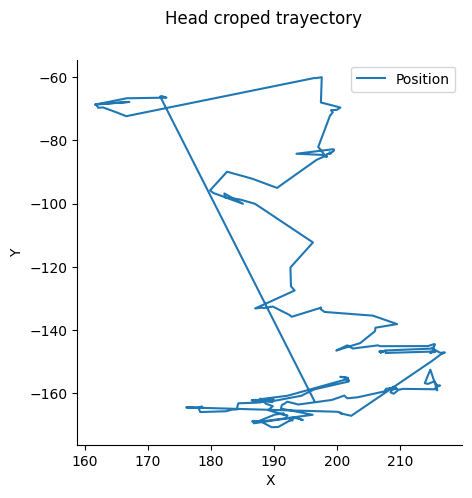

In [ ]:
# Croped trayectory Figure #

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Head croped trayectory')
ax1 = fig.add_subplot(111)

# Plot 1: Trayectory
ax1.plot(x_interp[:500], y_interp[:500], label='Position')
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()


## Speed
Now that we have interpolated data to obtain a continous trayectory, we can compute the mouse **speed**.

In [ ]:
dx = np.diff(x_interp)
dy = np.diff(y_interp)
distance = np.sqrt(dx**2 + dy**2)

time_intervals = x_interp.size - 1
total_time = time_intervals / frame_rate
time = np.linspace(0, total_time, time_intervals)

speed = distance / time

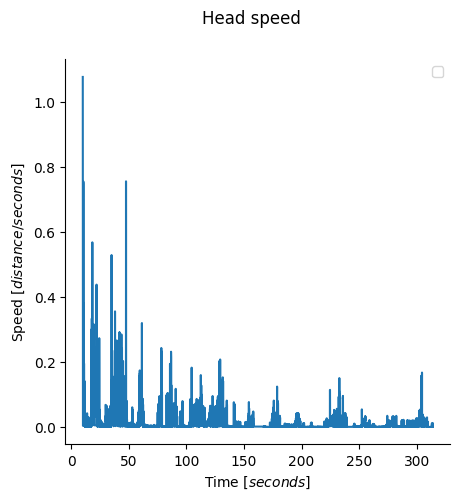

In [ ]:
# Speed Figure #

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Head speed')
ax1 = fig.add_subplot(111)

# Plot 1: Speed
ax1.plot(time[start_frame:], speed[start_frame:])
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('Time [$seconds$]')
ax1.set_ylabel('Speed [$distance/seconds$]')
ax1.legend()

## Aceleration
And the mouse **aceleration**.

In [ ]:
aceleration = np.diff(speed)

In [ ]:
# Aceleration Figure #

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Head acceleration')
ax1 = fig.add_subplot(111)

# Plot: Aceleration
ax1.plot(time[start_frame:-1], aceleration[start_frame:])
ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('Time [$seconds$]')
ax1.set_ylabel('Aceleration [$distance/seconds^2$]')
ax1.legend()

## Looking direction
To compute where the mouse is **looking** each frame, we can make the normalized sum of the two vectors formed by the nose and each two ears.

First, to avoid NaN values we will interpolate the filtered nose, and ear coordinates.

In [ ]:
filtered_data

In [ ]:
interpolated_data = filtered_data.copy()

# Interpolate right ear
nan_indices = np.isnan(filtered_data['nosex'])
interpolated_data['nosex'][nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data['nosex'][~nan_indices])
interpolated_data['nosey'][nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data['nosey'][~nan_indices])

# Interpolate left ear
nan_indices = np.isnan(filtered_data['leftearx'])
interpolated_data['leftearx'][nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data['leftearx'][~nan_indices])
interpolated_data['lefteary'][nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data['lefteary'][~nan_indices])

# Interpolate right ear
nan_indices = np.isnan(filtered_data['rightearx'])
interpolated_data['rightearx'][nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data['rightearx'][~nan_indices])
interpolated_data['righteary'][nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data['rightearx'][~nan_indices])

In [ ]:
interpolated_data

Now we can make the normalized sum of vectors and save them into a new table.

In [ ]:
directions_list = []

for n in range(0, interpolated_data['nosex'].size):
  nose_point = np.array([interpolated_data['nosex'][n], interpolated_data['nosey'][n]])
  leftear_point = np.array([interpolated_data['leftearx'][n], interpolated_data['lefteary'][n]])
  rightear_point = np.array([interpolated_data['rightearx'][n], interpolated_data['righteary'][n]])

  v_1 = nose_point - leftear_point
  v_2 = nose_point - rightear_point
  sum_v = v_1 + v_2
  norm_v = sum_v / np.linalg.norm(sum_v)
  directions_list.append(pd.DataFrame(norm_v))

# Convert the list of directions to a NumPy array
directions_array = np.array(directions_list)

# Reshape the array to make it 2D
directions_array = directions_array.reshape(-1, 2)

directions = pd.DataFrame(directions_array, columns=['x', 'y'])
directions


In [ ]:
# Calculate angles from direction vectors
angles = np.arctan2(directions['y'], directions['x']) * (360 / np.pi)

In [ ]:
# Looking directions Figure #

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = plt.subplot(122, polar=True)

# Plot 1: Trayectory looking directions
ax1.plot(x_interp, y_interp, label='Position')
ax1.quiver(x_interp, y_interp, directions['x'], directions['y'], color='r', scale=20)

ax1.set_box_aspect(1)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title('Trayectory looking directions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Plot 2: Looking direction frecuencies
ax2.hist(np.radians(angles), bins=np.radians(np.arange(0, 360, 10)), edgecolor='black', alpha=0.7)
ax2.set_theta_offset(np.radians(90))
ax2.set_theta_direction(-1)
ax2.set_rlabel_position(0)

ax2.set_title('Looking direction frecuencies (10-degree bins)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

fig.show()